# Land Use Classification using TensorFlow Transfer Learning
In this notebook, we illustrate how one can produce a deep learning model to classify aerial images based on land use type (developed, forested, cultivated, etc.). We apply transfer learning with MicrosoftML to adapt a pretrained featurizer for our classification use case.

<a name="prep"></a>
## Prepare deep learning framework-specific input files

If you have not generated your own training and validation sets through image extraction, download the following files and decompress them in your VM's temporary (`D:\`) storage:
- [Balanced training image set (~3 GB)](https://mawahstorage.blob.core.windows.net/aerialimageclassification/imagesets/balanced_training_set.zip)
- [Balanced validation image set (~1 GB)](https://mawahstorage.blob.core.windows.net/aerialimageclassification/imagesets/balanced_validation_set.zip)

The image sets linked above contain raw PNG images sorted into folders by their assigned label. Many deep learning frameworks require proprietary image formats or supporting files to efficiently load images in minibatches for training. We now produce the supporting files needed by our CNTK and TensorFlow training scripts. Note that we do not need to produce similar supporting files for the validation image set, because we will not use minibatching when applying the trained models to the validation set.

Update the `training_image_dir` variable below to reflect the directory where your training and validation sets have been saved. The `label_to_number_dict` variable specifies the correspondence between the label names and a numeric code; it does not need to be modified unless you have changed the labeling scheme.

In [9]:
import os
import glob
import numpy as np
import pandas as pd
from land_use.retrain import retrain
from sklearn.metrics import confusion_matrix, accuracy_score

import land_use.connection_settings as cs
import land_use.land_use_classification_utils as luc

repo_dir = cs.REPO_DIR
image_dir = cs.IMAGE_DIR
label_to_number_dict = cs.LABELS

# Autoreload when modules are changed
%load_ext autoreload
%autoreload 2

# Show matplotlib plots inline
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a name="tf"></a>
### TensorFlow

We made use of the [`tf-slim` API](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/slim) for TensorFlow, which provides pre-trained ResNet models and helpful scripts for retraining and scoring. These scripts require converting the image set into [TFRecords](https://www.tensorflow.org/how_tos/reading_data/#file_formats) for minibatching. (Each TFRecord contains many image files as well as their labels.) We also create a `labels.txt` file mapping the labels to integer values, and a `dataset_split_info.csv` file describing the images assigned to the training set.


In [3]:
np.random.seed(5318)

training_image_dir = os.path.join(cs.IMAGE_DIR, "TrainData")
training_filenames = luc.find_images(training_image_dir)
training_filenames = np.random.permutation(training_filenames)
df = luc.write_dataset('aerial', 'train', training_filenames, training_image_dir, n_shards=50)
df.to_csv(os.path.join(training_image_dir, 'dataset_split_info.csv'), index=False)

with open(os.path.join(training_image_dir, 'labels.txt'), 'w') as f:
    for key, value in label_to_number_dict.items():
        f.write('{}:{}\n'.format(key, value))
        
print("Done")

Found 44184 training images
Done


<a name="tensorflow"></a>
## Retrain a pretrained ResNet with TensorFlow

We made use of the [`tf-slim` API](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/slim) for TensorFlow, which provides pre-trained ResNet models and helpful scripts for retraining and scoring. During training set preparation, we created the [TFRecords](https://www.tensorflow.org/how_tos/reading_data/#file_formats) that the training script will use as input. For more details on the training data, please see the image preparation notebook in the [Embarrassingly Parallel Image Classification](https://github.com/Azure/Embarrassingly-Parallel-Image-Classification) repository. 

Our retraining file, `retrain.py` in the `tf` folder of [this repository](https://github.com/Azure/Embarrassingly-Parallel-Image-Classification), is a modified version of `train_image_classifier.py` from the [TensorFlow models repo's slim subdirectory](https://github.com/tensorflow/models/tree/master/slim).

Make sure that you have run [download_tf_models.py](utils/download_tf_models.py) prior to retraining.

In [ ]:
train_data = os.path.join(cs.IMAGE_DIR, 'TrainData')
train_dir = os.path.join(cs.IMAGE_DIR, "TFRetrainCheckpoints")

# Retrain the model. This can take hours.
retrain(train_data, train_dir)

Instructions for updating:
Use tf.losses.softmax_cross_entropy instead. Note that the order of the logits and labels arguments has been changed.


Instructions for updating:
Use tf.losses.softmax_cross_entropy instead. Note that the order of the logits and labels arguments has been changed.


Instructions for updating:
Use tf.losses.compute_weighted_loss instead.


Instructions for updating:
Use tf.losses.compute_weighted_loss instead.


Instructions for updating:
Use tf.losses.add_loss instead.


Instructions for updating:
Use tf.losses.add_loss instead.


INFO:tensorflow:Summary name /clone_loss is illegal; using clone_loss instead.


INFO:tensorflow:Summary name /clone_loss is illegal; using clone_loss instead.


INFO:tensorflow:Restoring parameters from \\Tyler-laptop\tylersqlserver\FileTableData\TFRetrainCheckpoints\model.ckpt-57


INFO:tensorflow:Restoring parameters from \\Tyler-laptop\tylersqlserver\FileTableData\TFRetrainCheckpoints\model.ckpt-57


## Score on the Validation Set

In [10]:
dataset_dir = os.path.join(cs.IMAGE_DIR, "ValData")
file_list = glob.glob('{}/*/*.png'.format(dataset_dir))

start = pd.datetime.now()
results_tf = luc.score_model(file_list)
print('Scored {} images'.format(len(results_tf)))
stop = pd.datetime.now()
print(stop - start)

INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Restoring parameters from \\Tyler-laptop\tylersqlserver\FileTableData\TFRetrainCheckpoints\model.ckpt-57


INFO:tensorflow:Restoring parameters from \\Tyler-laptop\tylersqlserver\FileTableData\TFRetrainCheckpoints\model.ckpt-57


Scored 5880 images
0:37:53.254093


In [11]:
tf_df = pd.DataFrame(results_tf, columns=['filename', 'true_label', 'predicted_label'])

## Analyze Validation Results

Confusion matrix, without normalization


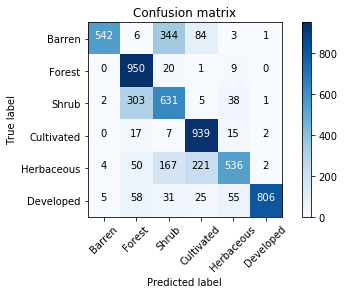

In [12]:
# Confusion matrix
y_pred = np.array(tf_df['predicted_label'])
y_true = np.array(tf_df['true_label'])
cm = confusion_matrix(y_true, y_pred)
luc.plot_confusion_matrix(cm, ["Barren", "Forest", "Shrub", "Cultivated", "Herbaceous", "Developed"])

In [13]:
# Accuracy (all classes)
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy (all classes): ", accuracy)

Accuracy (all classes):  0.748979591837


In [15]:
# Accuracy (Undeveloped, Cultivated, Developed)
y_true = luc.merge_classes(y_true)
y_pred = luc.merge_classes(y_pred)

accuracy = accuracy_score(y_true, y_pred)
print("Accuracy (Undeveloped, Cultivated, Developed): ", accuracy)

Accuracy (Undeveloped, Cultivated, Developed):  0.909863945578


## Score on the Test Set

In [16]:
dataset_dir = os.path.join(cs.IMAGE_DIR, "TestData")
file_list = glob.glob('{}/*/*.png'.format(dataset_dir))

start = pd.datetime.now()
results_tf = luc.score_model(file_list)
print('Scored {} images'.format(len(results_tf)))
stop = pd.datetime.now()
print(stop - start)

INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Restoring parameters from \\Tyler-laptop\tylersqlserver\FileTableData\TFRetrainCheckpoints\model.ckpt-57


INFO:tensorflow:Restoring parameters from \\Tyler-laptop\tylersqlserver\FileTableData\TFRetrainCheckpoints\model.ckpt-57


Scored 5880 images
0:42:21.972966


In [17]:
tf_df = pd.DataFrame(results_tf, columns=['filename', 'true_label', 'predicted_label'])

## Analyze Test Results

Confusion matrix, without normalization


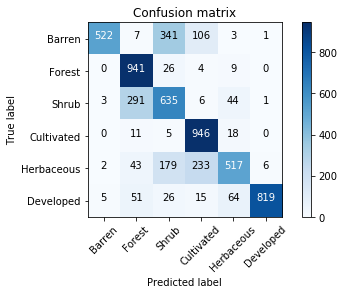

In [18]:
# Confusion matrix
y_pred = np.array(tf_df['predicted_label'])
y_true = np.array(tf_df['true_label'])
cm = confusion_matrix(y_true, y_pred)
luc.plot_confusion_matrix(cm, ["Barren", "Forest", "Shrub", "Cultivated", "Herbaceous", "Developed"])

In [19]:
# Accuracy (all classes)
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy (all classes): ", accuracy)

Accuracy (all classes):  0.744897959184


In [20]:
# Accuracy (Undeveloped, Cultivated, Developed)
y_true = luc.merge_classes(y_true)
y_pred = luc.merge_classes(y_pred)

accuracy = accuracy_score(y_true, y_pred)
print("Accuracy (Undeveloped, Cultivated, Developed): ", accuracy)

Accuracy (Undeveloped, Cultivated, Developed):  0.90612244898
